# HW250527-Image_Classification_Problems

## Exercise 2
* Use VGG net (VGG13, VGG16, or VGG19) to solve the image classification problem
* the dataset is CIFAR-100 provided by torchvision.datasets. Use coarse class labels (# classes is 20)
* You can make proper modifications on VGG nets.
* Discuss your modifications and recognition results

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

### use_deterministic_algorithms
注意: 本案例未使用。
``` Python
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
```
用來支援 
``` Python
torch.use_deterministic_algorithms(True)
```
### os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
由於環境改為本地端執行，疑似 matplotlib 有問題，造成 kernel 無法執行。
目前使用此方法迴避。

In [2]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# torch.use_deterministic_algorithms(True)
torch.use_deterministic_algorithms(False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### VGG13
* 輸出 out_features 改為 20，用來匹配 CIFAR-100。
* to(device)
``` Python
vgg13.to(device)
```
model 搬到 device 裡面計算，優先使用 GPU CUDA 而非 CPU

In [3]:
from torchvision.models.vgg import VGG13_Weights
from torchvision import models
# model = models.vgg13(weights=VGG13_Weights.DEFAULT)
vgg13 = models.vgg13()
vgg13.classifier[6] = nn.Linear(in_features=4096, out_features=20, bias=True)
vgg13.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): 

### def train(net, trainloader, optim, epoch)
1. 從 trainloader 取資料
2. Activation -> backpropagation算梯度 -> optim更新
3. 每 1000 次 印出 Loss
* to(device)
``` Python
ip = ip.to(device)
ground_truth = ground_truth.to(device)
```

In [4]:
def train(net, trainloader, optim, epoch):
    # initialize loss
    loss_total = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # ip refers to the input images, and ground_truth refers to the output classes the images belong to
        ip, ground_truth = data
        ip           = ip.to(device)
        ground_truth = ground_truth.to(device)

        # zero the parameter gradients
        optim.zero_grad()

        # forward pass + backward pass + optimization step
        op = net(ip)
        loss = nn.CrossEntropyLoss()(op, ground_truth)
        loss.backward()
        optim.step()

        # update loss
        loss_total += loss.item()
        
        # print loss statistics
        if (i+1) % 1000 == 0:    # print at the interval of 1000 mini-batches
            print('[Epoch number : %d, Mini-batches: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss_total / 1000))
            loss_total = 0.0

### def test(net, testloader):
* to(device)
``` Python
im = im.to(device)
ground_truth = ground_truth.to(device)
```

In [5]:
def test(net, testloader):
    success = 0
    counter = 0
    with torch.no_grad():
        for data in testloader:
            im, ground_truth = data
            
            im           = im.to(device)
            ground_truth = ground_truth.to(device)
            
            op = net(im)
            _, pred = torch.max(op.data, 1)
            counter += ground_truth.size(0)
            success += (pred == ground_truth).sum().item()
    print("counter", counter)
    print('Accuracy on test dataset: %d %%' % (
        100 * success / counter))

### Dataset
* CIFAR-100  
https://www.cs.toronto.edu/~kriz/cifar.html
* sparse2coarse  
source: https://github.com/ryanchankh/cifar100coarse/blob/master/sparse2coarse.py  
將 class 從 100 收斂到 20 個，回傳值有更改為tensor型態。
* Resize  
將CIFAR-100 的影像resize成 224\*224

In [6]:
from torchvision.datasets import CIFAR100

# https://github.com/ryanchankh/cifar100coarse/blob/master/sparse2coarse.py
def sparse2coarse(targets):
    """Convert Pytorch CIFAR100 sparse targets to coarse targets.

    Usage:
        trainset = torchvision.datasets.CIFAR100(path)
        trainset.targets = sparse2coarse(trainset.targets)
    """
    coarse_labels = np.array([ 4,  1, 14,  8,  0,  6,  7,  7, 18,  3,  
                               3, 14,  9, 18,  7, 11,  3,  9,  7, 11,
                               6, 11,  5, 10,  7,  6, 13, 15,  3, 15,  
                               0, 11,  1, 10, 12, 14, 16,  9, 11,  5, 
                               5, 19,  8,  8, 15, 13, 14, 17, 18, 10, 
                               16, 4, 17,  4,  2,  0, 17,  4, 18, 17, 
                               10, 3,  2, 12, 12, 16, 12,  1,  9, 19,  
                               2, 10,  0,  1, 16, 12,  9, 13, 15, 13, 
                              16, 19,  2,  4,  6, 19,  5,  5,  8, 19, 
                              18,  1,  2, 15,  6,  0, 17,  8, 14, 13])
    return torch.tensor(coarse_labels[targets]).long()

# The mean and std are kept as 0.5 for normalizing pixel values as the pixel values are originally in the range 0 to 1
# train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
#                                       transforms.RandomCrop(32, 4),
#                                       transforms.ToTensor(),
#                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_transform = transforms.Compose([transforms.Resize(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainset = CIFAR100(root='./data_CIFAR100', train=True, download=True, transform=train_transform)
trainset.targets = sparse2coarse(trainset.targets)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)


# test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transform = transforms.Compose([transforms.Resize(224), 
                                     transforms.ToTensor(), 
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    ])

# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testset = CIFAR100(root='./data_CIFAR100', train=False, download=True, transform=test_transform)
testset.targets = sparse2coarse(testset.targets)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)


# ordering is important
# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = ('aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables',
           'household electrical devices', 'household furniture', 'insects', 'large carnivores', 'large man-made outdoor things',
           'large natural outdoor scenes', 'large omnivores and herbivores', 'medium-sized mammals', 'non-insect invertebrates', 'people',
           'reptiles', 'small mammals', 'trees', 'vehicles 1', 'vehicles 2',
          )

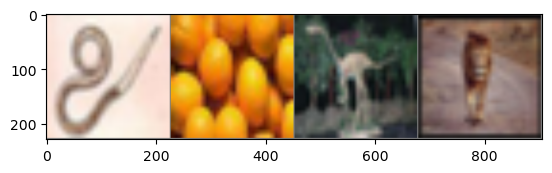

    non-insect invertebrates  ||  fruit and vegetables  ||  reptiles  ||  large carnivores


In [7]:
# define a function that displays an image
def imageshow(image):
    # un-normalize the image
    image = image/2 + 0.5     
    npimage = image.numpy()
    plt.imshow(np.transpose(npimage, (1, 2, 0)))
    plt.show()


# sample images from training set
dataiter = iter(trainloader)
images, labels = next(dataiter)

# display images in a grid
num_images = 4
imageshow(torchvision.utils.make_grid(images[:num_images]))
# print labels
print('    '+'  ||  '.join(classes[(labels[j])] for j in range(num_images)))

In [8]:
# define optimizer
optim = torch.optim.Adam(vgg13.parameters(), lr=1e-4)

# training loop over the dataset multiple times
for epoch in range(30):  
    train(vgg13, trainloader, optim, epoch)
    print()
    print("testing")
    test(vgg13, testloader)
    print()

print('Finished Training')

[Epoch number : 1, Mini-batches:  1000] loss: 2.898
[Epoch number : 1, Mini-batches:  2000] loss: 2.579
[Epoch number : 1, Mini-batches:  3000] loss: 2.395
[Epoch number : 1, Mini-batches:  4000] loss: 2.274
[Epoch number : 1, Mini-batches:  5000] loss: 2.132
[Epoch number : 1, Mini-batches:  6000] loss: 2.062

testing
counter 10000
Accuracy on test dataset: 38 %

[Epoch number : 2, Mini-batches:  1000] loss: 1.899
[Epoch number : 2, Mini-batches:  2000] loss: 1.822
[Epoch number : 2, Mini-batches:  3000] loss: 1.780
[Epoch number : 2, Mini-batches:  4000] loss: 1.748
[Epoch number : 2, Mini-batches:  5000] loss: 1.688
[Epoch number : 2, Mini-batches:  6000] loss: 1.636

testing
counter 10000
Accuracy on test dataset: 49 %

[Epoch number : 3, Mini-batches:  1000] loss: 1.442
[Epoch number : 3, Mini-batches:  2000] loss: 1.427
[Epoch number : 3, Mini-batches:  3000] loss: 1.403
[Epoch number : 3, Mini-batches:  4000] loss: 1.392
[Epoch number : 3, Mini-batches:  5000] loss: 1.350
[Epoch

In [9]:
model_path = './VGG13_CIFAR100_model.pth'
torch.save(vgg13.state_dict(), model_path)

In [22]:
torch.cuda.empty_cache()

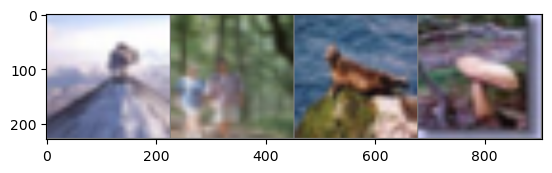

Label:       large natural outdoor scenes || large natural outdoor scenes || aquatic mammals || fruit and vegetables
Prediction:  large natural outdoor scenes || large carnivores || aquatic mammals || fruit and vegetables


In [19]:
# load test dataset images
d_iter = iter(testloader)
im, ground_truth = next(d_iter)

# print images and ground truth
imageshow(torchvision.utils.make_grid(im[:4]))
print('Label:      ', ' || '.join('%5s' % classes[ground_truth[j]] for j in range(4)))

# load model
vgg13_cached = vgg13
vgg13_cached.load_state_dict(torch.load(model_path))
vgg13_cached.eval()

# model inference
im = im.to(device)
ground_truth = ground_truth.to(device)
op = vgg13_cached(im)

# print predictions
_, pred = torch.max(op, 1)

print('Prediction: ', ' || '.join('%5s' % classes[pred[j]] for j in range(4)))
torch.cuda.empty_cache()

In [20]:
success = 0
counter = 0
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        im = im.to(device)
        ground_truth = ground_truth.to(device)
        op = vgg13_cached(im)
        _, pred = torch.max(op.data, 1)
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()

print('Model accuracy on test dataset: %d %%' % (
    100 * success / counter))
torch.cuda.empty_cache()

Model accuracy on test dataset: 64 %


In [25]:
class_sucess = list(0. for i in range(20))
class_counter = list(0. for i in range(20))
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        im = im.to(device)
        ground_truth = ground_truth.to(device)
        op = vgg13_cached(im)
        _, pred = torch.max(op, 1)
        c = (pred == ground_truth).squeeze()
        for i in range(100):
            ground_truth_curr = ground_truth[i]
            class_sucess[ground_truth_curr] += c[i].item()
            class_counter[ground_truth_curr] += 1


for i in range(20):
    print('Model accuracy for class %5s : %2d %%' % (
        classes[i], 100 * class_sucess[i] / class_counter[i]))

torch.cuda.empty_cache()

Model accuracy for class aquatic mammals : 48 %
Model accuracy for class  fish : 68 %
Model accuracy for class flowers : 85 %
Model accuracy for class food containers : 61 %
Model accuracy for class fruit and vegetables : 70 %
Model accuracy for class household electrical devices : 68 %
Model accuracy for class household furniture : 63 %
Model accuracy for class insects : 71 %
Model accuracy for class large carnivores : 60 %
Model accuracy for class large man-made outdoor things : 77 %
Model accuracy for class large natural outdoor scenes : 81 %
Model accuracy for class large omnivores and herbivores : 53 %
Model accuracy for class medium-sized mammals : 49 %
Model accuracy for class non-insect invertebrates : 48 %
Model accuracy for class people : 64 %
Model accuracy for class reptiles : 38 %
Model accuracy for class small mammals : 49 %
Model accuracy for class trees : 94 %
Model accuracy for class vehicles 1 : 70 %
Model accuracy for class vehicles 2 : 62 %
